In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

from matplotlib.colors import ListedColormap
cm_bright = ListedColormap(['#FF0000', '#0000FF'])
%matplotlib inline
from sklearn.metrics import accuracy_score

import sklearn.linear_model

In [2]:
def plot_surface(cls, x_1, x_2, ax=None, threshold=0.5, contourf=False):
    xx1, xx2 = np.meshgrid(np.linspace(x_1.min(), x_1.max(), 100), 
                           np.linspace(x_2.min(), x_2.max(), 100))

    X_pred = np.c_[xx1.ravel(), xx2.ravel()]
    pred = cls.predict_proba(X_pred)[:, 0]
    Z = pred.reshape((100, 100))
    if ax is None:
        ax = plt.gca()
    ax.contour(xx1, xx2, Z, levels=[threshold], colors='black')
    ax.set_xlim((x_1.min(), x_1.max()))
    ax.set_ylim((x_2.min(), x_2.max()))

In [3]:
def plot_data(X, y):
    ax = plt.gca()
    ax.scatter(X[:,0], X[:,1], c=(y == 1), cmap=cm_bright)

In [4]:
class NeuralNet:
    
    def __init__(self, hidden_layer_sizes, normalize = True, learning_rate = 0.01, num_iter = 30000, precision = None):
        self.learning_rate = learning_rate
        self.num_iter = num_iter
        self.normalize = normalize
        
        self.hidden_layer_sizes = hidden_layer_sizes
        self.precision = precision
       
    def __normalize(self, X, mean = None, std = None):
        n = X.shape[0]
        m = mean
        if m is None:
            m = np.mean(X, axis=1).reshape((n, 1))
        s = std
        if s is None:
            s = np.std(X, axis=1).reshape((n, 1))
        X_new = (X - m) / s**2
        return X_new, m, s
  
    def __sigmoid(self, Z):
        return 1 / (1 + np.exp(-Z))

    def __initialize_parameters(self):
        hidden_layer_sizes = self.hidden_layer_sizes
        parameters = {}
        for l in range(1, len(hidden_layer_sizes)):
            parameters['W' + str(l)] = np.random.randn(hidden_layer_sizes[l], hidden_layer_sizes[l-1]) * 0.01
            parameters['b' + str(l)] = np.zeros((hidden_layer_sizes[l], 1))
        self.parameters = parameters
             
    def __forward_linear_activation(self, A_prev, W, b):   
        Z = np.dot(W, A_prev) + b
        linear_cache = (A_prev, W, b)
        A = self.__sigmoid(Z)
        activation_cache = Z
        cache = (linear_cache, activation_cache)
        return A, cache
    
    def __multilayer_forward(self, X):       
        parameters = self.parameters
        caches = []
        A = X
        L = len(parameters) // 2
        for l in range(1, L):
            A_prev = A 
            A, cache = self.__forward_linear_activation(A_prev, parameters["W"+str(l)], parameters["b"+str(l)])
            caches.append(cache)   
        AL, cache = self.__forward_linear_activation(A, parameters["W"+str(L)], parameters["b"+str(L)])
        caches.append(cache)
        assert(AL.shape == (1,X.shape[1]))
        return AL, caches
    
    def __backward_linear_activation(self, dA, cache):
        
        linear_cache, activation_cache = cache
        Z = activation_cache
        s = 1/(1+np.exp(-Z))
        dZ = dA * s * (1-s)
        A_prev, W, b = linear_cache
        m = A_prev.shape[1]
        dW = 1 / m * np.dot(dZ, A_prev.T)
        db = 1 / m * np.sum(dZ, axis=1, keepdims=True)
        dA_prev = np.dot(W.T, dZ)
        return dA_prev, dW, db

    def __multilayer_backward(self, X, Y, caches):
        grads = {}
        AL = X
        L = len(caches)
        m = AL.shape[1]
        Y = Y.reshape(AL.shape)
        dAL = -(np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
        current_cache = caches[L-1]
        grads["dA" + str(L-1)], grads["dW" + str(L)], grads["db" + str(L)] = self.__backward_linear_activation(dAL, current_cache)
        for l in reversed(range(L-1)):
            current_cache = caches[l]
            dA_prev_temp, dW_temp, db_temp = self.__backward_linear_activation(grads["dA" + str(l + 1)], current_cache)
            grads["dA" + str(l)] = dA_prev_temp
            grads["dW" + str(l + 1)] = dW_temp
            grads["db" + str(l + 1)] = db_temp  
        return grads
      
    def compute_cost(self, A, Y):
        m = Y.shape[1]
        res = Y * np.log(A) + (1 - Y) * np.log(1 - A)
        J = -(1 / m) * np.sum(res)
        return J
   
    def __update_parameters(self, grads):
        parameters = self.parameters;
        learning_rate = self.learning_rate
        L = len(parameters) // 2
        for l in range(L):
            parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate * grads["dW" + str(l+1)]
            parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate * grads["db" + str(l+1)]       
        self.parameters = parameters;
        
    
    def fit(self, X_vert, Y_vert, print_cost = True):
        
        X, Y = X_vert.T, Y_vert.T
        if self.normalize:
            X, self.__mean, self.__std = self.__normalize(X)
        costs = []
        self.__initialize_parameters()
        for i in range(0, self.num_iter):
            AL, caches = self.__multilayer_forward(X)
            cost = self.compute_cost(AL, Y)
            grads = self.__multilayer_backward(AL, Y, caches) 
            self.__update_parameters(grads)
            if print_cost and i % 100 == 0:
                print ("Cost after iteration %i: %f" %(i, cost))
            if print_cost and i % 100 == 0:
                costs.append(cost) 
                if len(costs) > 1 and self.precision != None and np.abs(costs[-2] - costs[-1]) < self.precision:
                    print('Stopping gradient descent ...')
                    break
        if print_cost:
                plt.plot(costs)
                plt.ylabel("Cost")
                plt.xlabel("Iteration, *100")
                plt.show()

    def predict_proba(self, X_vert):
        X = X_vert.T
        if self.normalize:
            X, _, _ = self.__normalize(X, self.__mean, self.__std)
        probs = self.__multilayer_forward(X)[0]
        return np.column_stack((probs.T, 1 - probs.T))
    
    def predict(self, X_vert):
        positive_probs = self.predict_proba(X_vert)[:, 0]
        return (positive_probs >= 0.5).astype(int)

In [5]:
#data_columns = ["exam1", "exam2"]
#target_column = "submitted"
#df = pd.read_csv("sats.csv")
#X, Y = df[data_columns].values, df[target_column].reshape((df.shape[0], 1))
#print('Training set: X={}, y={}'.format(X.shape, Y.shape))

In [6]:
data_columns = ["test1", "test2"]
target_column = "passed"
df = pd.read_csv("tests.csv")
X, Y = df[data_columns].values, df[target_column]
print('Training set: X={}, y={}'.format(X.shape, Y.shape))

Training set: X=(118, 2), y=(118,)


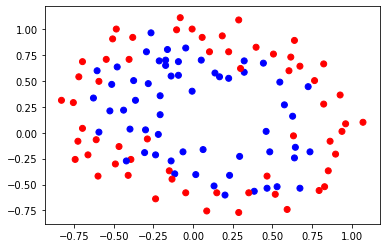

In [7]:
plot_data(X, Y)

In [8]:
#cls = NeuralNet(normalize = True, learning_rate = 0.5, num_iter = 4000)
cls = NeuralNet(hidden_layer_sizes = [2,2,1], normalize = True, learning_rate = 0.5, num_iter = 14000) 

In [9]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y.values.reshape((Y.shape[0], 1)), test_size = 0.2, random_state=10)

Cost after iteration 0: 0.693160
Cost after iteration 100: 0.689488
Cost after iteration 200: 0.689413
Cost after iteration 300: 0.689259
Cost after iteration 400: 0.688987
Cost after iteration 500: 0.688623
Cost after iteration 600: 0.688232
Cost after iteration 700: 0.687756
Cost after iteration 800: 0.686945
Cost after iteration 900: 0.685204
Cost after iteration 1000: 0.681422
Cost after iteration 1100: 0.674492
Cost after iteration 1200: 0.663255
Cost after iteration 1300: 0.643737
Cost after iteration 1400: 0.617130
Cost after iteration 1500: 0.595765
Cost after iteration 1600: 0.582412
Cost after iteration 1700: 0.574399
Cost after iteration 1800: 0.569332
Cost after iteration 1900: 0.565876
Cost after iteration 2000: 0.563352
Cost after iteration 2100: 0.561410
Cost after iteration 2200: 0.559853
Cost after iteration 2300: 0.558568
Cost after iteration 2400: 0.557481
Cost after iteration 2500: 0.556544
Cost after iteration 2600: 0.555721
Cost after iteration 2700: 0.554989
Cost

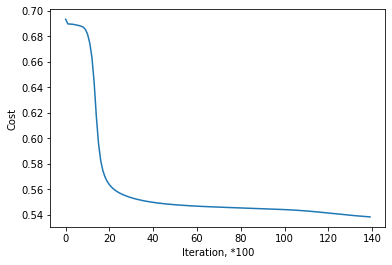

In [10]:
cls.fit(X_train, Y_train)

In [11]:
print(cls.parameters)

{'W1': array([[-2.10460404, -2.32472722],
       [-1.55044638, -2.98168334]]), 'b1': array([[-8.72824032],
       [ 8.8030582 ]]), 'W2': array([[-7.20025125,  6.26373212]]), 'b2': array([[-5.27561939]])}


In [12]:
Y_prob = cls.predict_proba(X)
Y_prob

array([[0.72539858, 0.27460142],
       [0.62368417, 0.37631583],
       [0.62145268, 0.37854732],
       [0.22510875, 0.77489125],
       [0.02662325, 0.97337675],
       [0.68995118, 0.31004882],
       [0.01281259, 0.98718741],
       [0.72848813, 0.27151187],
       [0.72797864, 0.27202136],
       [0.70912818, 0.29087182],
       [0.72444316, 0.27555684],
       [0.26550627, 0.73449373],
       [0.25098463, 0.74901537],
       [0.17416889, 0.82583111],
       [0.66047331, 0.33952669],
       [0.72204777, 0.27795223],
       [0.70534704, 0.29465296],
       [0.72859391, 0.27140609],
       [0.67330332, 0.32669668],
       [0.59771309, 0.40228691],
       [0.72367784, 0.27632216],
       [0.6848083 , 0.3151917 ],
       [0.70050317, 0.29949683],
       [0.08814259, 0.91185741],
       [0.72659033, 0.27340967],
       [0.67407634, 0.32592366],
       [0.19902907, 0.80097093],
       [0.67893486, 0.32106514],
       [0.64672397, 0.35327603],
       [0.71983867, 0.28016133],
       [0.

In [13]:
Y_hat = cls.predict(X)
Y_hat

array([1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1,
       0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1,
       0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1,
       1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 0, 1])

In [14]:
accuracy_score(Y, Y_hat)

0.711864406779661

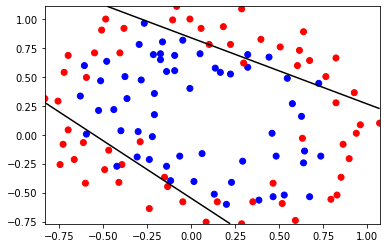

In [15]:
plot_data(X, Y)
plot_surface(cls, X[:, 0], X[:, 1])

In [16]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(hidden_layer_sizes = (20,), max_iter = 10000, activation = 'relu', solver = 'sgd', learning_rate_init = 0.01, learning_rate = 'constant')

In [17]:
clf.fit(X, Y)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(20,), learning_rate='constant',
              learning_rate_init=0.01, max_iter=10000, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='sgd', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

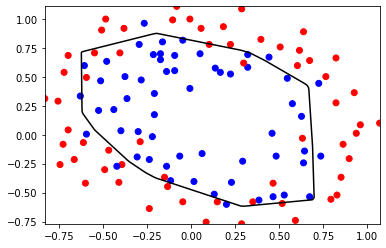

In [18]:
plot_data(X, Y)
plot_surface(clf, X[:, 0], X[:, 1])

In [19]:
accuracy_score(Y, clf.predict(X))

0.847457627118644